<a href="https://colab.research.google.com/github/PatrickSampaioUSP/Propy/blob/master/PropGoverningEquations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$r = aP^n$

In [1]:
class PressureOutOfBoundException(Exception):
  pass

class KnsbBurnrate:

  @classmethod
  def pressure_coefficient(cls, pressure):
    pressure_coefficient = 0
    if .101 <= pressure < .807:
      pressure_coefficient = 10.708
    elif .807 <= pressure < 1.503:
      pressure_coefficient = 8.763
    elif 1.503 <= pressure < 3.792:
      pressure_coefficient = 7.852
    elif 3.792 <= pressure < 7.033:
      pressure_coefficient = 3.907
    elif 7.033 <= pressure < 10.67:
      pressure_coefficient = 9.653
    else:
      raise PressureOutOfBoundException

    return pressure_coefficient

  @classmethod
  def pressure_exponential_coef(cls, pressure):
    pressure_exponential_coeficient = 0
    if .101 <= pressure < .807:
      pressure_exponential_coeficient = .625
    elif .807 <= pressure < 1.503:
      pressure_exponential_coeficient = -.314
    elif 1.503 <= pressure < 3.792:
      pressure_exponential_coeficient = -.013
    elif 3.792 <= pressure < 7.033:
      pressure_exponential_coeficient = .535
    elif 7.033 <= pressure < 10.67:
      pressure_exponential_coeficient = .064
    else:
      raise PressureOutOfBoundException

    return pressure_exponential_coeficient

  @classmethod
  def calculate_burnrate(cls, pressure):
    pressure_coef = cls.pressure_coefficient(pressure)
    pressure_exponential_coef = cls.pressure_exponential_coef(pressure)

    return pressure_coef*pressure**pressure_exponential_coef


In [2]:
from math import pi

class Motor:
  def __init__(self, r_throat, D0, d0, N, D_chamber, L=None, nozzle_exit_radius=None):
    self.r_throat = r_throat
    self.d_ext = D0
    self.d_int = d0
    self.grain_number = N
    self.D_chamber = D_chamber
    self.l_grain = L/N if L else (3*self.d_ext + self.d_int)/2
    self.nozzle_exit_radius = nozzle_exit_radius

  @property
  def throat_area(self):
    return math.pi*self.r_throat**2

  @property
  def web(self):
    return (self.d_ext-self.d_int)/2

  @property
  def chamber_length(self):
    return self.grain_number*self.l_grain

  @property
  def chamber_volume(self):
    return self.chamber_length*math.pi*(self.D_chamber**2)/4

  @property
  def propelent_volume(self):
    return (self.d_ext**2 - self.d_int**2)*self.chamber_length*math.pi

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import odeint, solve_ivp, trapz

############ Parameters #############
k = 1.1362                                            #Razão de calores específicos
cstar = 816.68                                        #Velocidade característica (m/s)
rho_grain = 1700.                                     #Densidade do grão (kg/m^3)
burn_rate = 7.72/1000                                 #Taxa de queima (m/s)
R_universal = 8.314*(10**3)                           #Constante universal dos gases (J/(kg K))
Mm = 39.9                                             #Massa molecular efetiva dos produtos de combustão (kg/kmol)
R = R_universal/Mm                                    #Constante dos produtos de combustão
T = 1600.                                             #Temperatura de combustão (K)
p_atm = 1.01325*(10**5)                               #Pressão atmosférica (Pa)
m_prod_chamber = 0.                                   #Massa dos produtos de combustão (kg)
n_cf = 0.8                                            #Eficiência do coeficiente de empuxo
g = 9.8                                               #Aceleração da gravidade (m/s^2)


################## FUNCOES ##################

calculate_pressure_steady = lambda x: x*rho_grain*burn_rate*cstar
calculate_nozzle_mass_flow = lambda pressure,throat_area: pressure*throat_area*math.sqrt(k/(R*T))*math.pow((2/(k+1)),((k+1)/(2*(k-1))))
#calculate_cf = lambda x: math.sqrt((2*k**2/(k-1))*((2/(k+1))**((k+1)/(k-1)))*(1-(p_atm/x)**((k-1)/k)))
calculate_thrust = lambda C,throat_area,x: C*throat_area*x

def calculate_cf(expansion_ratio,exit_pressure_list,pressure_list,exit_area,throat_area):
  cf = np.zeros(len(pressure_list))
  cf[0:len(cf)] = math.sqrt((2*k**2/(k-1))*((2/(k+1))**((k+1)/(k-1)))*(1-expansion_ratio**((k-1)/k))) + (exit_pressure_list[0:len(cf)] - p_atm)*exit_area/(throat_area*pressure_list[0:len(cf)])
  return cf

def calculate_current_prop_volume(grain_number, lgrain, d_ext, d_in):
  propelent_volume = grain_number*(((d_ext**2 - d_in**2)/4)*math.pi*lgrain)
  return propelent_volume

def calculate_current_burn_area(d_ext, d_in, lgrain, n):
  transversal_area = math.pi*(d_ext**2-d_in**2)*n/2
  longitudinal_area = math.pi*lgrain*d_in*n
  return longitudinal_area + transversal_area

############### MODELO #################

def modelo(t, y, motor):
    #d0 
    #lgrain
    #pressure
    #chamber combustion product mass
    ydot = [0, 0, 0, 0]
    # final da combustão dos grãos
    if D0 > y[0]:
      burn_rate = (10**-3)*KnsbBurnrate.calculate_burnrate(y[2]/(10**6))
    else:
      burn_rate = 0
    ydot[0] = 2*burn_rate
    ydot[1] = -1*ydot[0]
    
    current_prop_volume = calculate_current_prop_volume(motor.grain_number, y[1], motor.d_ext, y[0])
    free_volume = motor.chamber_volume - current_prop_volume
    #rho_o = y[3]/free_volume
    rho_o = y[2]/(R*T)

    burn_area = calculate_current_burn_area(D0, y[0], y[1], motor.grain_number)
    
    # massa que esta saindo dos grãos
    m_dot = burn_area*rho_grain*burn_rate
    nozzle_mass_flow = calculate_nozzle_mass_flow(y[2],motor.throat_area)
    ydot[3] = m_dot - nozzle_mass_flow
    ydot[2] = ((R*T)/free_volume) * (burn_area*burn_rate*(rho_grain-rho_o) - nozzle_mass_flow)
    return ydot

def solve(func, conditions, t, motor):
    d_ext_event = lambda t, y, motor: y[0] - motor.d_ext
    d_ext_event.terminal = True

    Y = solve_ivp(func, (0,t), conditions, args=(motor,), 
                  methods='RK45', max_step=0.001, events=[d_ext_event])
    return Y

def calculate_tail_off(motor, pressure):
  pressure_list = []
  time_list = []

  current_pressure = pressure
  dt = 0.01
  time = 0.01

  exponential_coef = -R*T*motor.throat_area/(motor.chamber_volume*cstar)
  while current_pressure > p_atm:
    current_pressure = pressure*math.exp(exponential_coef*time)
    time += dt

    pressure_list.append(current_pressure)
    time_list.append(time)

  return np.array(pressure_list), np.array(time_list)


def post_processing(y, time_vector, motor):
  tail_off_pressure, tail_off_time = calculate_tail_off(motor, y[2][-1])
  
  burn_time_vector = time_vector

  time_vector = np.hstack((time_vector, tail_off_time + time_vector[-1],))
  pressure_list = np.hstack((y[2], tail_off_pressure,))
  pressure_list = list(map(lambda x: x/10**5, pressure_list)) 

  mass_in_chamber_list = y[3]
  grain_length = y[1]
  grain_ext_d = y[0]

  mean_pressure = np.mean(pressure_list)*(10**5)
  if not motor.nozzle_exit_radius:
    exit_area_ideal = motor.throat_area/(math.pow((k+1)/2,1/(k-1))*math.pow(p_atm/mean_pressure,1/k)*math.sqrt((k+1)*(1-math.pow(p_atm/mean_pressure,(k-1)/k))/(k-1)))
    exit_radius = math.sqrt(exit_area_ideal/math.pi)*1000.
  else:
    exit_radius = motor.nozzle_exit_radius
    exit_area_ideal = math.pi*exit_radius**2

  f = lambda x: math.pow(x,1/k)*math.sqrt((k+1)*(1-math.pow(x,(k-1)/k))/(k-1)) - motor.throat_area*math.pow((k+1)/2,1/(1-k))/exit_area_ideal
  expansion_ratio = optimize.newton(f,p_atm/mean_pressure)
  exit_pressure_list = expansion_ratio*np.copy(pressure_list)

  cf = calculate_cf(expansion_ratio,exit_pressure_list,np.copy(pressure_list)*(10**5),exit_area_ideal,motor.throat_area)
  thrust_list = np.zeros(len(cf))
  burn_rate_list = np.zeros(len(cf))

  for j in range(len(pressure_list)):
    #cf[j]=n_cf*calculate_cf(pressure_list[j]*(10**5))
    thrust_list[j]=calculate_thrust(cf[j],motor.throat_area,pressure_list[j]*10**5)
    if j < len(burn_time_vector):
      state = [y[0][j], y[1][j], y[2][j], y[3][j]]
      burn_rate_list[j] = modelo(burn_time_vector[j],state,motor)[0]*1000/2

  average_burn_rate = np.mean(burn_rate_list)
  burn_time = motor.web*1000/average_burn_rate
  kn_list = list(map(lambda x: calculate_current_burn_area(D0, x[0], x[1], N)/motor.throat_area, zip(grain_ext_d, grain_length)))
  total_impulse = trapz(thrust_list, time_vector)

  specific_impulse = total_impulse/(g*motor.propelent_volume*rho_grain)
  upper = math.pi*motor.chamber_length*(motor.web**2 + motor.web*motor.d_int)*specific_impulse*(average_burn_rate/10**3)*rho_grain*g
  lower = motor.web*(1 + 2*(motor.chamber_length/motor.d_ext)) + (motor.chamber_length/motor.d_ext)*motor.d_int
  f_avg = upper/lower
  grain_ext_d = grain_ext_d*1000.

  plt.figure(figsize=(16,8),dpi=80)
  plt.subplot(4,1,1)
  plt.plot(time_vector,pressure_list)
  plt.ylabel('Pressao (bar)')
  plt.subplot(4,1,2)
  plt.plot(burn_time_vector,kn_list)
  plt.ylabel('Kn')
  plt.subplot(4,1,3)
  plt.plot(time_vector,thrust_list)
  plt.ylabel('Empuxo (N)')
  plt.subplot(4,1,4)
  plt.plot(burn_time_vector,grain_ext_d)
  plt.ylabel('Diametro (mm)')
  plt.xlabel('Tempo (s)')
  plt.show()

  print(f"Empuxo máximo {round(np.max(thrust_list), 2)} N")
  print(f"Pressão máxima {round(np.max(pressure_list), 2)} bar")
  print(f"Pressão média {round(np.mean(pressure_list), 2)} bar")
  print(f"Empuxo médio {round(np.mean(thrust_list), 2)} N")
  print(f"Empuxo médio {round(f_avg, 2)} N")
  print(f"Impulso total {round(total_impulse)} Ns")
  print(f"Taxa de queima média {round(average_burn_rate, 2)} mm/s")
  print(f"Tempo de queima {round(burn_time, 2)} s")
  print(f"Raio de saída do bocal {round(exit_radius, 2)} mm")
  print(f"Razão de expansão ideal {expansion_ratio}")

#### Motor Menotti

/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


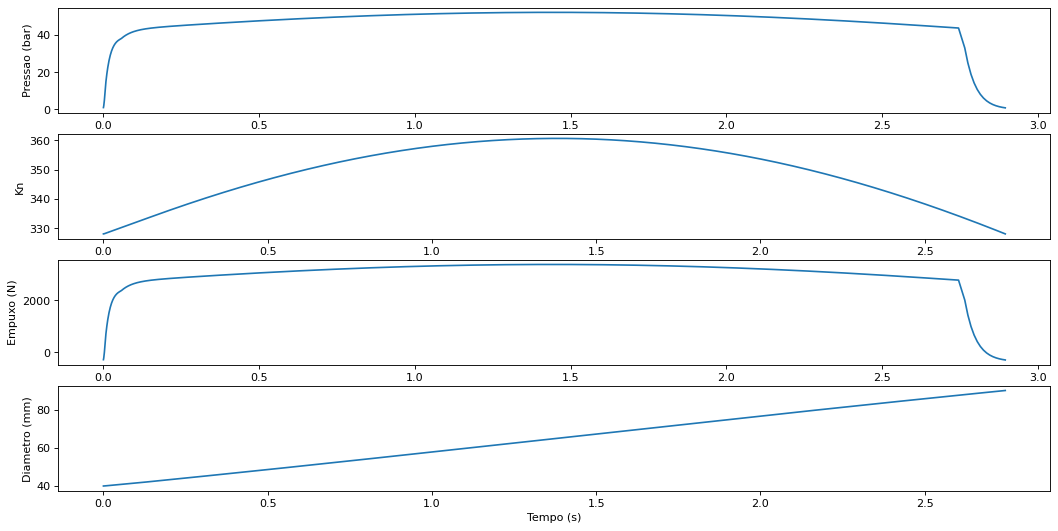

Empuxo máximo 3378.16 N
Pressão máxima 52.13 bar
Pressão média 48.34 bar
Empuxo médio 3107.15 N
Empuxo médio 24.49 N
Impulso total 8656.0 Ns
Taxa de queima média 9.06 mm/s
Tempo de queima 2.76 s
Raio de saída do bocal 33.24 mm
Razão de expansão ideal 0.020959032421973237


In [10]:
r_throat = 12/1000                                    #Raio da garganta do bocal (m)
D0 = 90./1000                                         #Diâmetro externo inicial (m)
N = 5                                                 #Número de grãos
d0 = 40./1000                                         #Diâmetro interno inicial (m)
D_chamber = 104./1000                                 #Diâmetro interno da câmara (m)
menotti = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber)

conditions = [menotti.d_int, menotti.l_grain, p_atm, m_prod_chamber]
t = np.linspace(0,2.8,100000)



y = solve(modelo, conditions, 3, menotti)
post_processing(y.y, y.t, menotti)

#### Motor Keron


/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


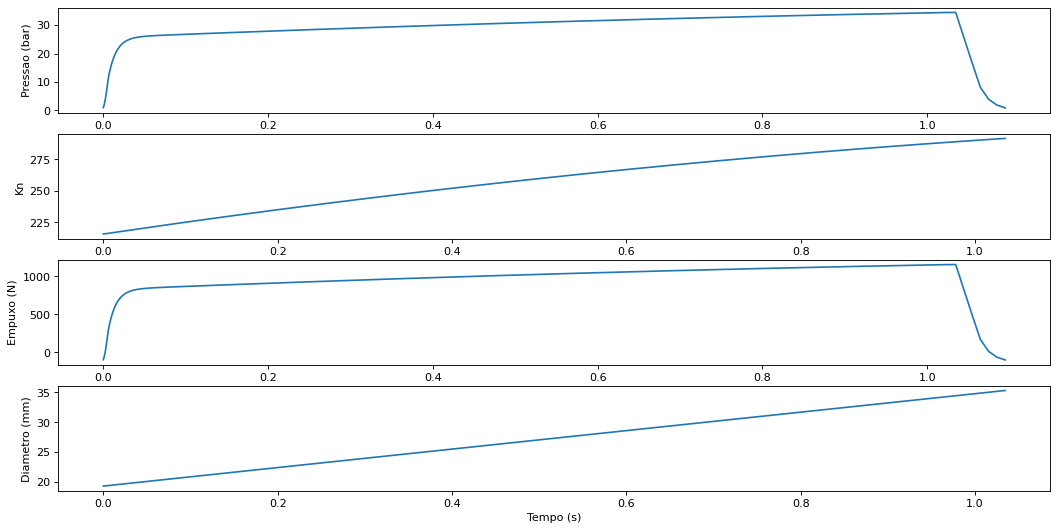

Empuxo máximo 1153.46 N
Pressão máxima 34.47 bar
Pressão média 30.23 bar
Empuxo médio 995.05 N
Empuxo médio 2.67 N
Impulso total 1054.0 Ns
Taxa de queima média 7.69 mm/s
Tempo de queima 1.04 s
Raio de saída do bocal 20.58 mm
Razão de expansão ideal 0.03351653064510638


In [5]:
r_throat = 8.9/1000                                   #Raio da garganta do bocal (m)
D0 = 35.3/1000                                        #Diâmetro externo (m)
N = 6                                                 #Número de grãos
d0 = 19.3/1000                                        #Diâmetro interno inicial (m)
D_chamber = 48.8/1000                                 #Diâmetro interno da câmara (m)
motor_length = 750/1000                               #Comprimento do motor (m)
keron = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber,
                L=motor_length)

conditions = [keron.d_int, keron.l_grain, p_atm, m_prod_chamber]
t = np.linspace(0,1.8,10000)

y = solve(modelo, conditions, 1.5, keron)
post_processing(y.y, y.t, keron)

In [6]:
keron.chamber_length

0.75

Pendencias:

- $\dot{M}_{nozzle}$ (check)
- $V_{camara}$ (check)
- $T_{combustion}$ (check)
- $R = \frac{\bar{R}}{M_M}$ (check)
- Tempo de queima e tail-off (check)
- $C_f$ variável com altidude
- Impulso total

#### Motor Mandioca


/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


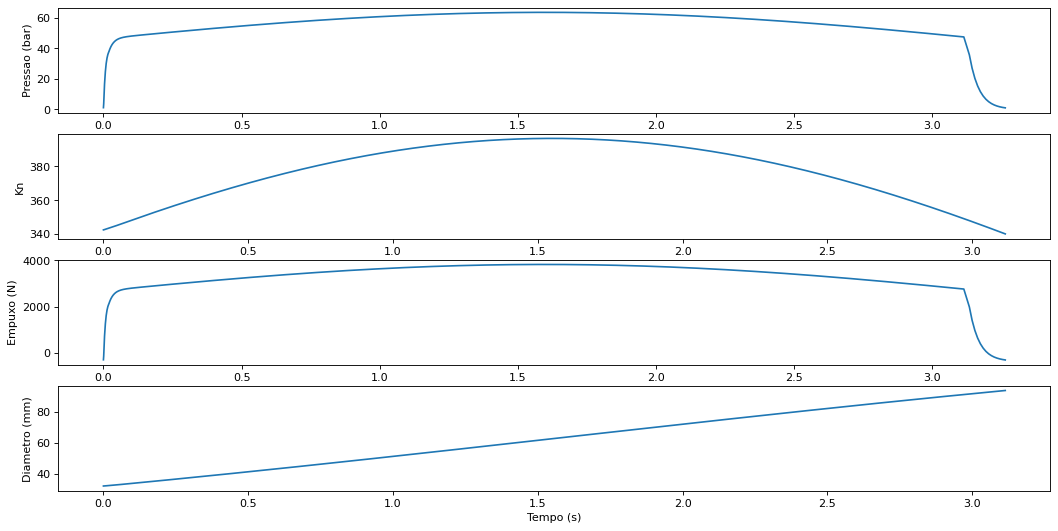

Empuxo máximo 3815.92 N
Pressão máxima 63.67 bar
Pressão média 57.28 bar
Empuxo médio 3397.37 N
Empuxo médio 32.7 N
Impulso total 10709.0 Ns
Taxa de queima média 9.9 mm/s
Tempo de queima 3.13 s
Raio de saída do bocal 0.03 mm
Razão de expansão ideal 0.01801883018605546


In [7]:
r_throat = 11.4/1000                                   #Raio da garganta do bocal (m)
D0 = 94/1000                                           #Diâmetro externo inicial (m)
N = 5                                                  #Número de grãos
d0 = 32/1000                                           #Diâmetro interno inicial (m)
D_chamber = 98/1000                                    #Diâmetro interno da câmara (m)
motor_length = 840/1000                                #Comprimento do motor (m)
#156
mandioca = Motor(r_throat=r_throat, 
                D0=D0, 
                d0=d0, 
                N=N, 
                D_chamber=D_chamber,
                L=motor_length,
                nozzle_exit_radius=33.5/1000)
mandioca.l_grain = 156/1000

conditions = [mandioca.d_int, mandioca.l_grain, p_atm, m_prod_chamber]
y = solve(modelo, conditions, 98, mandioca)
post_processing(y.y, y.t, mandioca)